Predict fuel efficiency

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.18.0


In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = dataset.dropna()

In [7]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [10]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

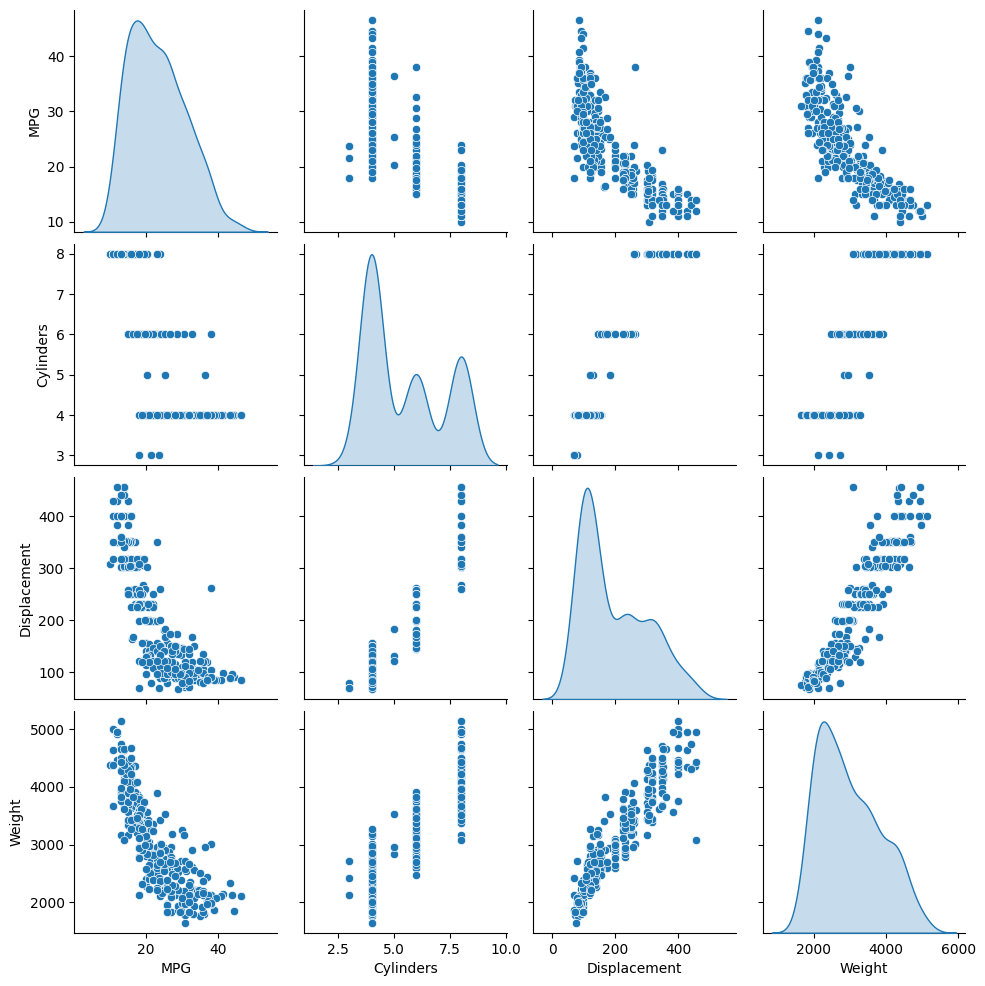

In [12]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [13]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [14]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [15]:
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

Normalization
In the table of statistics it's easy to see how different the ranges of each feature are:

In [16]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


Normalization is a technique used to rescale numeric data to a common range, usually between 0 and 1, to prevent features with large ranges from dominating the model

What does axis=-1 mean?
In TensorFlow, the default data format is batch_size, features or batch_size, sequence_length, features for sequential data. When axis=-1 is specified:
For 2D data (e.g., images or tabular data), axis=-1 refers to the feature axis (second axis).
For 3D data (e.g., sequences or time series), axis=-1 refers to the feature axis (third axis).

In [17]:
normalizer = tf.keras.layers.Normalization(axis=-1)

 fit the state of the preprocessing layer to the data by calling Normalization.adapt

In [18]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [19]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


When the layer is called, it returns the input data, with each feature independently normalized

In [20]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[4 90.0 75.0 2125.0 14.5 74 False False True]]



ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

Begin with a single-variable linear regression to predict 'MPG' from 'Horsepower'

In [21]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

d:\a27_YEARS_OLD\deep_learning\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [23]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[ 0.386],
       [ 0.218],
       [-0.712],
       [ 0.541],
       [ 0.489],
       [ 0.192],
       [ 0.579],
       [ 0.489],
       [ 0.127],
       [ 0.218]], dtype=float32)

In [24]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [26]:
%%time
train_history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=10,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 375 ms
Wall time: 772 ms


In [28]:
hist = pd.DataFrame(train_history.history)
hist['epoch'] = train_history.epoch
hist

,loss,val_loss,epoch
0,14.865207,14.932716,0
1,14.064079,14.133000,1
2,13.262886,13.332912,2
3,12.465448,12.532773,3
4,11.664653,11.733087,4
5,10.872110,10.944623,5
6,10.092327,10.177686,6
7,9.328956,9.406027,7
8,8.593367,8.656155,8
9,7.885219,7.923566,9


In [51]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([5, 25])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

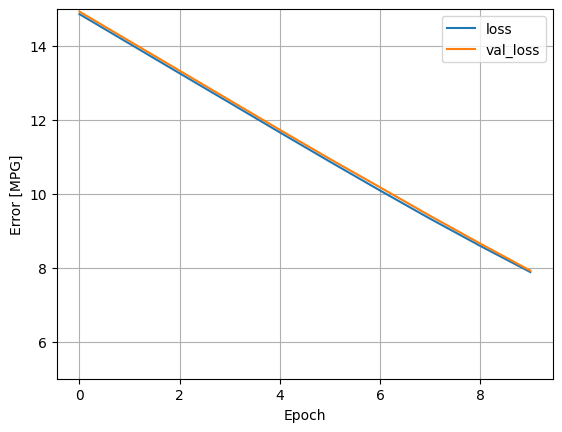

In [34]:
plot_loss(train_history)

In [ ]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)
# In other words, when verbose 0 is set, the program or command will:
# Not display detailed information or debug messages.
# Only show essential or error messages.
# Reduce or eliminate unnecessary output.

In [38]:
test_results

{'horsepower_model': 8.145559310913086}

In [36]:
x = tf.linspace(0.0, 250, 251)
print(x)

tf.Tensor(
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 

In [37]:
y = horsepower_model.predict(x)
y

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([[21.513],
       [21.459],
       [21.405],
       [21.351],
       [21.297],
       [21.243],
       [21.189],
       [21.135],
       [21.081],
       [21.027],
       [20.973],
       [20.919],
       [20.865],
       [20.811],
       [20.757],
       [20.703],
       [20.649],
       [20.595],
       [20.541],
       [20.487],
       [20.433],
       [20.379],
       [20.325],
       [20.271],
       [20.217],
       [20.163],
       [20.11 ],
       [20.056],
       [20.002],
       [19.948],
       [19.894],
       [19.84 ],
       [19.786],
       [19.732],
       [19.678],
       [19.624],
       [19.57 ],
       [19.516],
       [19.462],
       [19.408],
       [19.354],
       [19.3  ],
       [19.246],
       [19.192],
       [19.138],
       [19.084],
       [19.03 ],
       [18.976],
       [18.922],
       [18.868],
       [18.814],
       [18.76 ],
       [18.706],
       [18.652],
       [18.598],
       [18.544],
       [18.49 ],
       [18.436],
       [18.382

In [39]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()
  

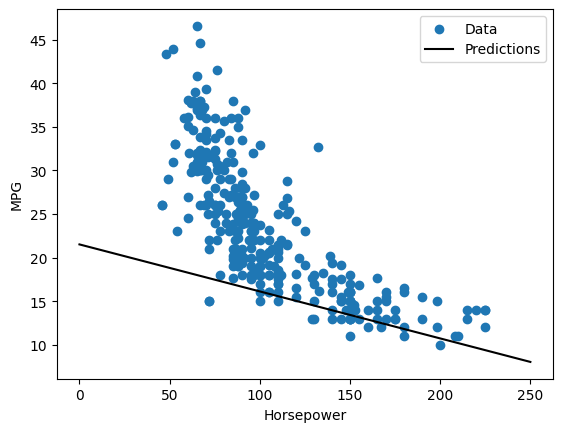

In [40]:
plot_horsepower(x, y)

Linear regression with multiple inputs

In [41]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [42]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


array([[-2.394],
       [-0.187],
       [ 2.168],
       [-1.213],
       [-0.829],
       [ 0.879],
       [-0.914],
       [ 0.714],
       [-0.   ],
       [-1.328]], dtype=float32)

When you call the model, its weight matrices will be built—check that the kernel weights (the 
 in 
) have a shape of (9, 1):

In [44]:
linear_model.layers[1].kernel

<KerasVariable shape=(9, 1), dtype=float32, path=sequential_1/dense_1/kernel>

In [45]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [46]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=10,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 1.02 s
Wall time: 1.64 s


In [49]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,val_loss,epoch
0,22.911926,23.045940,0
1,22.041214,22.310854,1
2,21.245127,21.646330,2
3,20.395662,20.923506,3
4,19.566607,20.201351,4
5,18.769312,19.457569,5
6,17.939524,18.752319,6
7,17.119125,18.019829,7
8,16.289665,17.280083,8
9,15.493502,16.578325,9


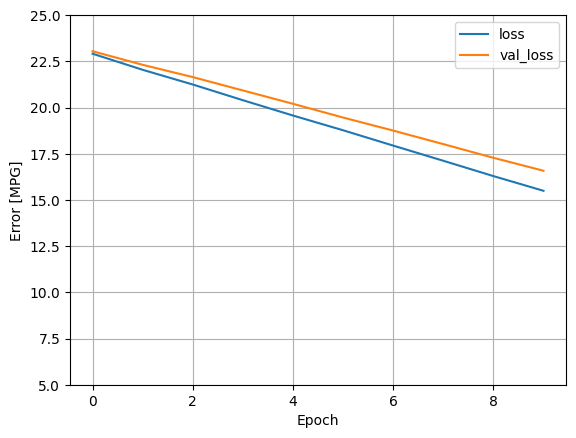

In [52]:
plot_loss(history)

In [53]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [54]:
test_results

{'horsepower_model': 8.145559310913086, 'linear_model': 15.783215522766113}

Regression with a deep neural network (DNN)

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

In [55]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

single input

In [63]:
horsepower_normalizer

<Normalization name=normalization_1, built=True>

This model has quite a few more trainable parameters than the linear models:

In [56]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [57]:
dnn_horsepower_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [59]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 5.05 s
Wall time: 8.15 s


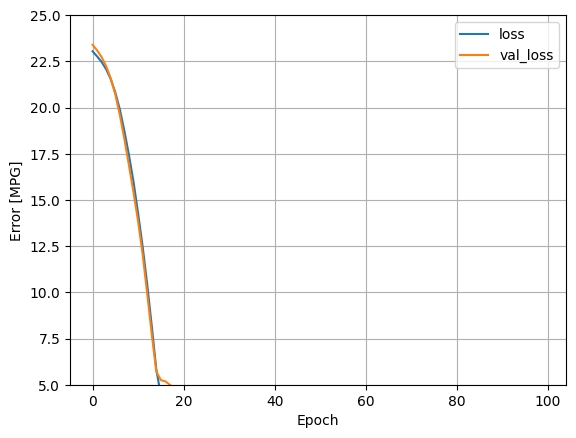

In [60]:
plot_loss(history)

If you plot the predictions as a function of 'Horsepower', you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:


x = tf.linspace(0.0, 250, 251)

In [61]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


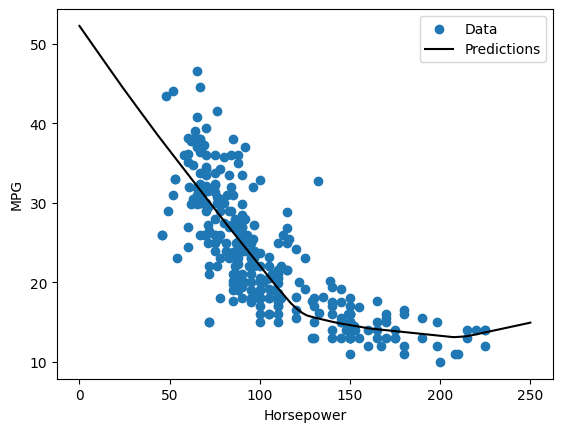

In [62]:
plot_horsepower(x, y)

In [64]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [65]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (10, 9)                │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [66]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 5 s
Wall time: 10.3 s


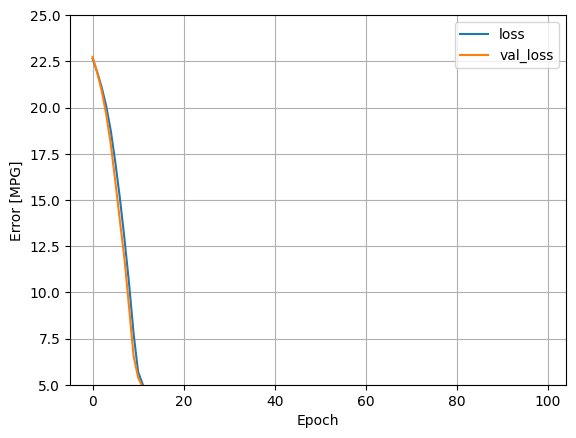

In [67]:
plot_loss(history)

In [68]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [69]:
test_predictions = dnn_model.predict(test_features).flatten()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [70]:
test_predictions

array([16.147, 11.739, 12.298, 24.681, 20.875, 13.28 , 13.76 , 12.873,
       19.135, 31.025, 24.451, 26.042, 15.264, 25.923, 13.317, 15.049,
       15.4  , 13.73 , 18.411, 13.447, 14.812, 25.539, 20.012, 21.352,
       29.952, 23.804, 16.519, 22.657, 17.653, 19.553, 27.743, 21.668,
       18.728, 20.967, 26.004, 16.507, 18.968, 30.538, 29.557, 17.702,
       30.406, 28.666, 16.382, 34.778, 34.338, 35.303, 20.693, 22.162,
       20.713, 25.518, 30.43 , 17.638, 31.72 , 18.591, 17.831, 17.969,
       32.731, 34.234, 22.734, 25.164, 37.787, 32.279, 27.309, 27.59 ,
       32.04 , 38.457, 35.71 , 35.586, 33.316, 29.543, 22.225, 22.477,
       29.489, 30.491, 35.729, 34.843, 37.098, 30.082], dtype=float32)

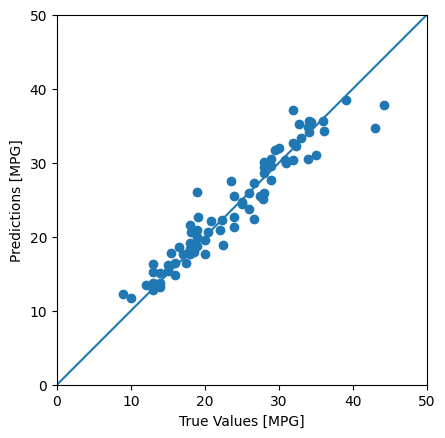

In [71]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

 check the error distribution:

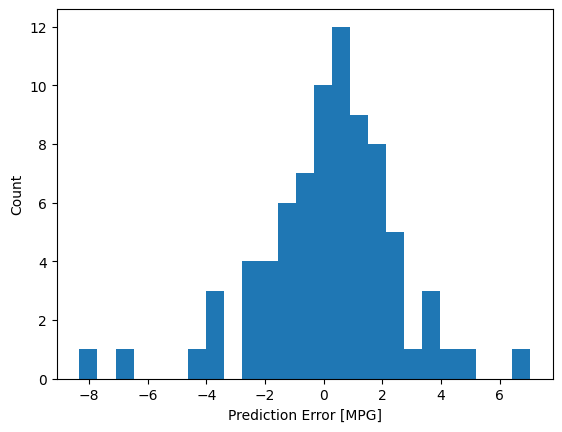

In [72]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [73]:
dnn_model.save('dnn_model.keras')

In [74]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

If you reload the model, it gives identical output:

In [75]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,8.145559
linear_model,15.783216
dnn_horsepower_model,2.886972
dnn_model,1.725044
reloaded,1.725044
